In [1]:
'''
如何将文本消息分类为垃圾短信或正常短信

微调语言模型最常见的方法是指令微调和分类微调
指令微调：通过在一组任务上使用特定指令训练模型，用以提升模型对自然语言提示中任务描述的理解和执行能力
分类微调：模型被训练用来识别特定的一组类别标签
'''

'''
1： 准备数据集
'''
# Downloading and unzipping the dataset
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return
    with urllib.request.urlopen(url) as response:          #A
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    with zipfile.ZipFile(zip_path, "r") as zip_ref:        #B
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)          #C
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


#A 下载数据集
#B 解压数据集
#C 为解压的数据集文件设置.tsv文件扩展名

File downloaded and saved as sms_spam_collection\SMSSpamCollection.tsv


In [2]:
import pandas as pd
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df      #A

#A 在 Jupyter Notebook 中可以直接渲染数据，或者用 print(df) 命令显示数据内容

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [3]:
# 统计分类情况
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [4]:
'''
我们选择对数据集进行下采样，每个类别保留 747 个样本，为了更快的进行微调

'''
# Creating a balanced dataset
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]                                 #A
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)      #B
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])              #C
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())


#A 统计垃圾短信的实例数量
#B 随机抽取正常邮件实例，使其数量与垃圾短信实例相同。
#C 将正常短信子集与垃圾短信合并


Label
ham     747
spam    747
Name: count, dtype: int64


In [5]:
# 将字符串类别标签 "ham" 和 "spam" 分别转换为整数类别标签 0 和 1
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

'''
创建一个random_split函数，将数据集划分为三部分：70%用于训练，10%用于验证，20%用于测试
'''
# Splitting the dataset
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)     #A

    train_end = int(len(df) * train_frac)                               #B
    validation_end = train_end + int(len(df) * validation_frac)

    train_df = df[:train_end]                                           #C
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)  #D


#A 将整个 DataFrame 随机打乱
#B 计算数据分割的索引
#C 分割 DataFrame
#D 测试集默认大小为 0.2（即剩余部分）

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [7]:
'''
2： 创建数据加载器

为了像第 2 章中的文本块那样对这些消息进行批处理，我们有两种处理方式：

将所有消息截断至数据集或批次中最短消息的长度。
将所有消息填充到数据集或批次中最长消息的长度。

方案一的计算成本较低，但如果较短的消息远小于平均长度或最长消息长度，可能会导致显著的信息损失，从而降低模型的性能。因此，我们选择方案二，以完整保留所有消息的内容。
'''
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

# 定义SpamDataset类：识别训练数据集中最长的序列，对文本消息进行编码，并确保通过填充 token 将其他序列补齐到与最长序列相同的长度
# Setting up a Pytorch Dataset class
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        self.encoded_texts = [                                      #A
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length

            self.encoded_texts = [                                  #B
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        self.encoded_texts = [                                      #C
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


#A 对文本进行预分词
#B 若序列超过最大长度则进行截断
#C 将序列填充至最长序列长度

[50256]


In [9]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

120


In [11]:
# Creating PyTorch data loaders
# 创建训练集、验证集和测试集的数据加载器，以批量大小为 8 加载文本消息及其标签
from torch.utils.data import DataLoader

num_workers = 0                  #A
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

#A 此设置可确保与大多数计算机兼容

# 为了确保数据加载器正常工作并确实返回了预期大小的批次数据，可以遍历训练集数据加载器，并打印最后一个批次的张量维度

for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
130 training batches
19 validation batches
38 test batches


In [12]:
'''
3: 使用预训练权重初始化模型
'''

CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0, # Dropout rate
    "qkv_bias": True # Query-key-value bias
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [20]:
# Loading a pretrained GPT model
from ch_5.gpt_download import download_and_load_gpt2
from ch_4.build_gpt import GPTModel, generate_text_simple
from ch_5.ch5 import load_weights_into_gpt, text_to_token_ids, token_ids_to_text

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

# 将模型权重加载到GPTModel后，我们使用前面章节的文本生成工具函数，确保模型能够生成连贯的文本
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json


model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [15:06<00:00, 549kiB/s]    
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 5.34MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 2.28MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 5.43MiB/s]


Every effort moves you forward.

The first step is to understand the importance of your work


In [2]:
# 看看这个模型是否能通过给它提供指令来对垃圾短信进行分类
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

NameError: name 'generate_text_simple' is not defined

In [22]:
'''
4： 添加分类头

为分类任务的微调做准备：
输出层将隐层表示映射到50,257个词汇的词汇表，而我们用一个较小的输出层将其映射到两个类别：0（‘非垃圾短信’）和1（‘垃圾短信’）
'''
print(model)


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [23]:
# 只微调最后几层（接近输出层），它们更专注于细致的语言模式和任务特定的特征，通常就足够使模型适应新任务
# 为了让模型准备好进行分类微调，我们首先通过将所有层设为不可训练来冻结模型
for param in model.parameters():
    param.requires_grad = False

# Adding a classification layer
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)

# 这个新的输出层 model.out_head 的 requires_grad 属性默认为 True，意味着它是模型训练过程中唯一会被更新的层
# 为了让最终的 LayerNorm 和最后一个 Transformer 模块参与训练，将它们的 requires_grad 设置为 True

for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

# 尽管我们增加了一个新的输出层，并标记了某些层为可训练或不可训练，我们仍然可以像前几章那样使用这个模型
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

with torch.no_grad():
    outputs = model(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)  # shape: (batch_size, num_tokens, num_classes)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])
Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [24]:
# 我们不需要微调所有 4 行输出，只需聚焦于单个输出 token。具体来说，我们将重点关注最后一行对应的输出 token
# To extract the last output token, illustrated in figure 6.11, from the output tensor, we use the following code:
print("Last output token:", outputs[:, -1, :])

# 因果注意力掩码设置中，序列中的最后一个 token 聚合了所有前面 token 的信息。因此，在垃圾短信分类任务的微调过程中，我们会重点关注这个最后的 token

Last output token: tensor([[-3.5983,  3.9902]])


In [27]:
'''
5： 计算分类损失和准确率
'''
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print(label)
print("Class label:", label.item())

logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

tensor(1)
Class label: 1
Class label: 1


In [28]:
# 为了计算分类准确率，我们对数据集中的所有样本进行 argmax 预测，并通过定义一个 calc_accuracy_loader 函数来计算预测正确的比例
# Calculating the classification accuracy
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]                   #A
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

#A 最后一个输出 token 的 logits 值

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 可以使用这个函数来估算多个数据集上的分类准确率，为提高效率，这里基于 10 个批次的结果进行估算
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [29]:
'''
定义损失函数，以便在训练过程中对其进行优化：最大化模型的垃圾短信分类准确率，因此代码输出应为正确的类别标签：0 表示正常短信，1 表示垃圾短信
'''
# 与之前的区别是：我们只优化最后一个 token（model(input_batch)[:, -1, :]），而不是整个序列中的所有 token（model(input_batch)）
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :] # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

# Calculating the classification loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:                                      #A
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

# Similar to calculating the training accuracy, we now compute the initial loss for each data set:
with torch.no_grad():                           #B
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)


#A 确保批次数不超过数据加载器中的总批次数
#B 关闭梯度追踪以提高效率，因为当前未进行训练

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


In [31]:
'''
6: 使用监督数据对模型进行微调
'''

# 与之前的唯一区别：现在记录的是训练样本数量（examples_seen），而不是 token 数量；并且在每个 epoch 后计算准确率，而不再打印示例文本
# Finetuning the model to classify spam
def train_classifier_simple(model, train_loader, val_loader, optimizer, device,
num_epochs, eval_freq, eval_iter, tokenizer):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()                                      #A

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()                          #B
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()                                #C
            optimizer.step()                               #D
            examples_seen += input_batch.shape[0]          #E
            global_step += 1


            if global_step % eval_freq == 0:               #F
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        train_accuracy = calc_accuracy_loader(             #G
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen


#A 设置模型为训练模式
#B 重置上一批次的损失梯度
#C 计算损失梯度
#D 使用损失梯度更新模型权重
#E 更改逻辑：跟踪样本数量而非 token 数量
#F 可选评估步骤
#G 每个 epoch 后计算准确率

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 12.17 m

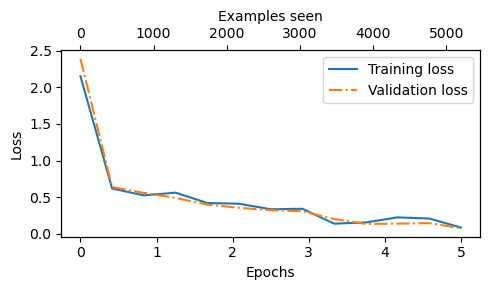

In [33]:
# Plotting the classification loss
import matplotlib.pyplot as plt
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")    #A
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()                                                 #B
    ax2.plot(examples_seen, train_values, alpha=0) # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()                                                #C
    plt.savefig(f"{label}-plot.pdf")
    plt.show()


#A 绘制训练轮次与训练和验证损失的变化图
#B 创建一个新的 x 轴，用于显示已处理样本数
#C 调整布局以留出空间

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

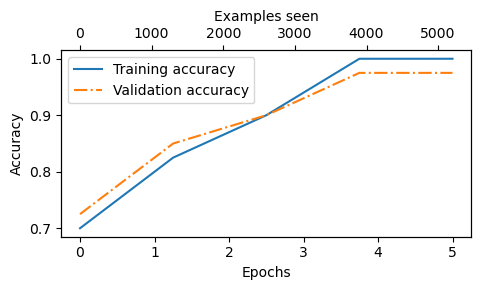

In [34]:
# 绘制分类准确率曲线
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [35]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

# 训练集和测试集准确率之间的轻微差异表明训练数据的过拟合程度较低

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


In [1]:
'''
7: 将 LLM 用于垃圾短信分类

使用微调后的基于 GPT 的垃圾短信分类模型
'''

# Using the model to classify new texts
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text)                                   #A
    supported_context_length = model.pos_emb.weight.shape[1]

    input_ids = input_ids[:min(max_length, supported_context_length)]    #B

    input_ids += [pad_token_id] * (max_length - len(input_ids))          #C
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)   #D

    with torch.no_grad():                                                #E
        logits = model(input_tensor)[:, -1, :]                           #F
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"                #G


#A 准备模型输入
#B 截断过长序列
#C 填充序列至最长长度
#D 增加批次维度
#E 关闭梯度跟踪，进行模型推理
#F 获取最后一个输出 token 的 logits
#G 返回分类结果

text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

NameError: name 'model' is not defined

In [40]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)
print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

# 保存模型
torch.save(model.state_dict(), "review_classifier.pth")

not spam


In [42]:
# 重新加载模型
model_state_dict = torch.load("review_classifier.pth")
model.load_state_dict(model_state_dict)

<All keys matched successfully>